# QRNN Thai2Fit Classification

This notebook demonstrates how to use the [ULMFit model](https://arxiv.org/abs/1801.06146) implemented by`thai2fit` for text classification. We use [Wongnai Challenge: Review Rating Prediction](https://www.kaggle.com/c/wongnai-challenge-review-rating-prediction) as our benchmark as it is the only sizeable and publicly available text classification dataset at the time of writing (June 21, 2018). It has 39,999 reviews for training and validation, and 6,203 reviews for testing. Our workflow is as follows:

* Perform 85/15 train-validation split
* Minimal text cleaning and tokenization using `newmm` engine of `pyThaiNLP`
* Get embeddings of Wongnai dataset from all the data available (train and test sets)
* Load pretrained Thai Wikipedia embeddings; for those embeddings which exist only in Wongnai dataset, we use the average of Wikipedia embeddings instead
* Train language model based on all the data available on Wongnai dataset
* Replace the top and train the classifier based on the training set by gradual unfreezing

![alt text](../wongnai_data/misc/submission.jpg "Submission")

![alt text](../wongnai_data/misc/leaderboard.jpg "Leaderboards")

## Imports

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import dill as pickle
from collections import Counter
from pathlib import Path
from sklearn.model_selection import train_test_split


from fastai.text import *
import fastai
from pythainlp.ulmfit import *
import pythainlp


DATA_PATH='../wongnai_data/'
RAW_PATH = f'{DATA_PATH}raw/'
MODEL_PATH = f'{DATA_PATH}models/'

raw_files = !ls {RAW_PATH}

## Train/Validation Sets

We use data from [Wongnai Challenge: Review Rating Prediction](https://www.kaggle.com/c/wongnai-challenge-review-rating-prediction). The training data consists of 39,999 restaurant reviews from unknown number of reviewers labeled one to five stars, with the schema `(label,review)`. We use 85/15 train-validation split. The test set has 6,203 reviews from the same number of reviewers. No information accuracy is 46.9%.

In [2]:
raw_train = pd.read_csv(f'{RAW_PATH}w_review_train.csv',sep=';',header=None)
raw_train = raw_train.iloc[:,[1,0]]
raw_train.columns = ['label','review']
raw_test = pd.read_csv(f'{RAW_PATH}test_file.csv',sep=';')
submission =  pd.read_csv(f'{RAW_PATH}sample_submission.csv',sep=',')

In [3]:
print(raw_train.shape)
raw_train.head()

(40000, 2)


,label,review
0,3,ร้านอาหารใหญ่มากกกกกกก \nเลี้ยวเข้ามาเจอห้องน้...
1,4,อาหารที่นี่เป็นอาหารจีนแคะที่หากินยากในบ้านเรา...
2,3,ปอเปี๊ยะสด ทุกวันนี้รู้สึกว่าหากินยาก (ร้านที่...
3,5,รัานคัพเค้กในเมืองไทยมีไม่มาก หลายๆคนอาจจะสงสั...
4,5,อร่อย!!! เดินผ่านDigital gatewayทุกวัน ไม่ยักร...


In [4]:
cnt = Counter(raw_train['label'])
cnt

Counter({3: 12171, 4: 18770, 5: 6799, 2: 1845, 1: 415})

In [5]:
#baseline
cnt.most_common(1)[0][1] / raw_train.shape[0]

0.46925

In [6]:
raw_test.head()

,reviewID,review
0,1,ร้านนี้จะอยู่เส้นสันกำแพง-แม่ออน เลยแยกบ่...
1,2,สั่งไป2 เมนู คือมัชฉะลาเต้ร้อน กับ ไอศครีมชาเข...
2,3,ครัววงเดือน \n\nหิวดึกๆ ตระเวนหาร้านทาน มาเจอ...
3,4,จะว่าเป็นเจ้าประจำก็คงไม่ผิด แต่ก็ไม่กล้า...
4,5,ถ้าคิดถึงสลัดผมคิดถึงร้านนี้เป็นร้านแรกๆเลยครั...


In [7]:
submission.head()

,reviewID,rating
0,1,4
1,2,3
2,3,3
3,4,4


In [8]:
#test df
raw_test = pd.read_csv(f'{RAW_PATH}test_file.csv',sep=';')
df_tst = pd.DataFrame({'label':raw_test['reviewID'],'review':raw_test['review']})
df_tst.to_csv(f'{DATA_PATH}test.csv', header=False, index=False)

In [9]:
#train/validation/train_language_model split for fastText validation
df_trn, df_val = train_test_split(raw_train, test_size = 0.15, random_state = 1412)

df_trn.to_csv(f'{DATA_PATH}train_fasttext.csv', header=False, index=False)
df_val.to_csv(f'{DATA_PATH}valid_fasttext.csv', header=False, index=False)

In [10]:
#combine train and validation for our classification and use everything for our language modeling
df_trn = raw_train.copy()
df_lm = pd.concat([df_trn,df_tst])
df_trn.to_csv(f'{DATA_PATH}train.csv', header=False, index=False)
df_lm.to_csv(f'{DATA_PATH}train_lm.csv', header=False, index=False)

In [11]:
df_trn.shape,df_val.shape,df_lm.shape

((40000, 2), (6000, 2), (46203, 2))

## Language Modeling

### Text Processing

We first determine the vocab for the reviews, then train a language model based on our training set. We perform the following  text processing:

* Fix html tags to plain texts
* Lowercase all English words and if a word is written in all caps, we put it in a lower case and add `xxup` before
* Repetitive characters: Thai usually emphasizes adjectives by repeating the last character such as `อร่อยมากกกกกกก` to `อร่อยมาก xxrep 7 ` so that the word still retains its original form. 
* Normalize character order: for instance `นำ้` to `น้ำ`
* Add spaces around / and #
* Remove multiple spaces and newlines
* Remove empty brackets of all types (`([{`) which might result from cleaning up
* `pyThaiNLP`'s `newmm` word tokenizer with frozen dictionary (`engine ='ulmfit'`)  is used to tokenize the texts.

In [12]:
# tt = Tokenizer(tok_func = ThaiTokenizer, lang = 'th', rules = thai_rules)
# data_lm = TextLMDataBunch.from_csv(path = Path(DATA_PATH),csv_name='train_lm.csv',valid_pct=0.1,
#                                   tokenizer=tt, vocab = None)
# data_lm.save('lm_db')

In [13]:
data_lm = TextLMDataBunch.load(DATA_PATH,'lm_db',bs=64)

In [14]:
len(data_lm.vocab.itos)

21749

In [15]:
data_lm.vocab.itos[3:13]

['ร้าน', '\n', 'มา', 'ที่', 'ๆ', 'มี', 'ก็', 'ไม่', 'เลย', 'ค่ะ']

In [16]:
len(data_lm.valid_ds), len(data_lm.train_ds)

(4620, 41582)

### Load Pretrained Language Model

Instead of starting from random weights, we import the language model pretrained on Wikipedia (see `pretrained_wiki.ipynb`). For words that appear only in the Wongnai dataset but not Wikipedia, we start with the average of all embeddings instead. Max vocab size is set at 60,000 and minimum frequency of 2 consistent with the pretrained model.

### Train Domain-Specific Language Model

In [25]:
#heuristic reference from imdb_scripts
learn = language_model_learner(data_lm, bptt = 70, emb_sz = 400, nh = 1550, nl = 3,
                                  drop_mult = 0.3, bias = True, qrnn = True, 
                                  alpha=2, beta = 1,
                                  pretrained_fnames = pythainlp.ulmfit._THWIKI_QRNN)
learn.metrics = [accuracy]
learn.opt_func = partial(optim.Adam, betas=(0.8, 0.99))
learn.wd = 1e-7

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


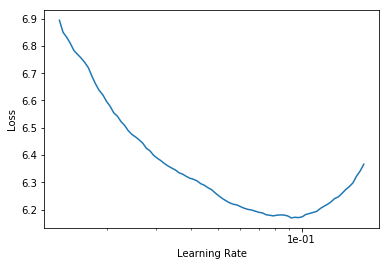

In [28]:
learn.lr_find(start_lr = 1e-2, end_lr=0.2)
learn.recorder.plot()

In [36]:
#heuristic reference from imdb_scripts
learn = language_model_learner(data_lm, bptt = 70, emb_sz = 400, nh = 1550, nl = 3,
                                  drop_mult = 0.1, bias = True, qrnn = True, 
                                  alpha=2, beta = 1, clip=1.,
                                  pretrained_fnames = THWIKI)
learn.metrics = [accuracy]
learn.opt_func = partial(optim.Adam, betas=(0.8, 0.99))

In [37]:
#optimal learning rate and wd
lr = 1e-2
wd = 1e-7
learn.freeze()

In [38]:
#train frozen
learn.fit_one_cycle(cyc_len = 1, 
                    max_lr= lr, #learning rate
                    div_factor=20, #factor to discount from max
                    moms = (0.8, 0.7), #momentums
                    pct_start = 0.1, #where the peak is at 
                    wd = wd #weight decay
                   ) 

Total time: 08:19
epoch  train_loss  valid_loss  accuracy
1      5.055595    4.809116    0.259951  (08:19)



In [102]:
#train unfrozen
learn.unfreeze()
learn.fit_one_cycle(cyc_len = 5, 
                    max_lr= lr, #learning rate
                    div_factor=20, #factor to discount from max
                    moms = (0.8, 0.7), #momentums
                    pct_start = 0.3, #where the peak is at 
                    wd = wd #weight decay
                   ) 

Total time: 47:24
epoch  train_loss  valid_loss  accuracy
1      4.521193    4.358531    0.281094  (09:30)
2      4.340217    4.252639    0.285999  (09:31)
3      4.158906    4.068014    0.301785  (09:28)
4      4.017428    3.984598    0.308997  (09:25)
5      3.940736    3.962245    0.311535  (09:27)



In [103]:
# learn.save('wongnai_lm_qrnn')
# learn.save_encoder('wongnai_enc_qrnn')

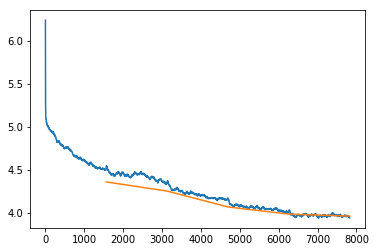

In [104]:
learn.recorder.plot_losses()

In [39]:
learn.load('wongnai_lm')
print('LM loaded')

LM loaded


In [40]:
''.join(predict_sentence('ร้านนี้ดี',learn,data_lm,20))

'ครับ เมนูที่สั่งวันนี้คือ 1. ข้าวหมูกรอบ (50 บาท) '

In [41]:
''.join(predict_sentence('อาหารอร่อย',learn,data_lm,10))

'ล้ำค่ะ เมนูที่สั่งมาทานวันนี้คือ'

In [42]:
predict_word('ร้านนี้ดี',learn,data_lm)

['ครับ', 'ค่ะ', ' ', 'จริงๆ', 'ไม่น้อย']

## Classification

With the language model trained on Wongnai dataset, we use its embeddings to initialize the review classifier. We train the classifier using discriminative learning rates, slanted triangular learning rates, gradual unfreezing and a few other tricks detailed in the [ULMFit paper](https://arxiv.org/abs/1801.06146). We have found that training only the last two layers of the model seems to be the right balance for this dataset.

### Data Bunch

Create another data bunch this time for classification, using the same vocab as the our finetuned language model.

In [18]:
# tt = Tokenizer(tok_func = ThaiTokenizer, lang = 'th', rules = thai_rules)
# data_clas = TextClasDataBunch.from_csv(path=Path(DATA_PATH), csv_name='train.csv', valid_pct = 0.15, 
#                  test = 'test.csv', tokenizer=tt, vocab=data_lm.vocab)
# data_clas.save('clas_db')

In [17]:
data_clas = TextClasDataBunch.load(DATA_PATH,'clas_db',bs=64)

In [18]:
data_clas.train_ds.y.classes

[4, 3, 2, 5, 1]

In [19]:
#check if using right vocab
len(data_clas.vocab.itos)==len(data_lm.vocab.itos)

True

In [20]:
len(data_clas.vocab.itos)

21749

### Model

We create a text classifier by combining our finetuned encoder with a linear model.

In [36]:
#heuristic reference from imdb_scripts
learn = text_classifier_learner(data_clas, bptt = 70, emb_sz = 400, nh = 1550, nl = 3,
                                  drop_mult = 0.3, qrnn = True, clip = 1.,
                                  alpha=2, beta = 1)
learn.metrics = [accuracy]
learn.opt_func = partial(optim.Adam, betas=(0.7, 0.99))
learn.wd=1e-7
learn.load_encoder('wongnai_enc_qrnn')

In [37]:
learn.model

SequentialRNN(
  (0): MultiBatchRNNCore(
    (encoder): Embedding(21749, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(21749, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): QRNNLayer(
        (linear): WeightDropout(
          (module): Linear(in_features=800, out_features=4650, bias=True)
        )
      )
      (1): QRNNLayer(
        (linear): WeightDropout(
          (module): Linear(in_features=1550, out_features=4650, bias=True)
        )
      )
      (2): QRNNLayer(
        (linear): WeightDropout(
          (module): Linear(in_features=1550, out_features=1200, bias=True)
        )
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.12)
      (2): Linear(in_fe

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


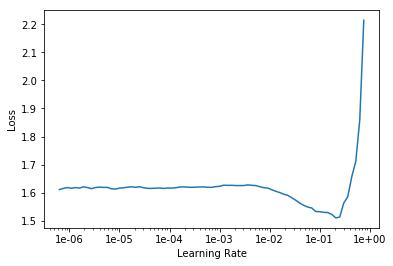

In [38]:
#select max lr
learn.lr_find()
learn.recorder.plot()

### Training

In [21]:
#heuristic reference from imdb_scripts
learn = text_classifier_learner(data_clas, bptt = 70, emb_sz = 400, nh = 1550, nl = 3,
                                  drop_mult = 0.2, qrnn = True, clip=10.,
                                  alpha=2, beta = 1)
learn.metrics = [accuracy]
learn.opt_func = partial(optim.Adam, betas=(0.7, 0.99))
learn.load_encoder('wongnai_enc')

In [46]:
#frozen
lr = 0.02
learn.freeze_to(-1)
learn.fit_one_cycle(cyc_len = 3, 
                    max_lr= lr, #learning rate
                    div_factor=10, #factor to discount from max
                    moms = (0.8, 0.7), #momentums
                    pct_start = 0.3, #where the peak is at 
                    wd = 1e-6
                   ) 
learn.save('frozen')

Total time: 11:17
epoch  train_loss  valid_loss  accuracy
1      1.182626    1.258669    0.467167  (03:51)
2      1.131923    1.203100    0.489500  (03:46)
3      1.103224    1.209326    0.498833  (03:40)



In [47]:
#gradual unfreeze 1
lr = 0.01
learn.load('frozen')
learn.freeze_to(-2)
learn.fit_one_cycle(cyc_len = 3, 
                    max_lr= slice(lr/(2.6**4),lr), #learning rate
                    div_factor=10, #factor to discount from max
                    moms = (0.8, 0.7), #momentums
                    pct_start = 0.3, #where the peak is at 
                    wd = 1e-6
                   ) 
learn.save('unfreeze_1')

Total time: 11:48
epoch  train_loss  valid_loss  accuracy
1      1.130945    1.233015    0.468667  (04:01)
2      1.090084    1.224546    0.477000  (03:53)
3      1.089605    1.174924    0.494833  (03:53)



In [48]:
#gradual unfreeze 2
lr = 0.005
learn.load('unfreeze_1')
learn.freeze_to(-3)
learn.fit_one_cycle(cyc_len = 3, 
                    max_lr= slice(lr/(2.6**4),lr), #learning rate
                    div_factor=10, #factor to discount from max
                    moms = (0.8, 0.7), #momentums
                    pct_start = 0.3, #where the peak is at 
                    wd = 1e-6
                   ) 
learn.save('unfreeze_2')

Total time: 14:58
epoch  train_loss  valid_loss  accuracy
1      1.066597    1.159384    0.497167  (05:14)
2      1.062794    1.188423    0.494667  (04:49)
3      1.068656    1.164858    0.500333  (04:53)



In [22]:
#totally unfrozen
lr = 0.0025
learn.load('unfreeze_2')
learn.unfreeze()
learn.fit_one_cycle(cyc_len = 5, 
                    max_lr= slice(lr/(2.6**4),lr), #learning rate
                    div_factor=10, #factor to discount from max
                    moms = (0.8, 0.7), #momentums
                    pct_start = 0.3, #where the peak is at 
                    wd = 1e-6
                   ) 
learn.save('unfrozen')

Total time: 36:27
epoch  train_loss  valid_loss  accuracy
1      1.045483    1.182001    0.500500  (07:03)
2      1.035142    1.253205    0.483667  (06:51)
3      1.040669    1.156537    0.494667  (07:54)
4      1.031111    1.134155    0.516000  (07:40)
5      1.018597    1.116635    0.520333  (06:56)

